# Notebook for parsing BIST stock data

Possible sources: 
1. **Oyak Yatırım API**: 
  * `code`: stock code (TUKAS, CRDFA etc.)
  * `mode`:
    * 0: last day
    * 1: last week
    * 2: last month
    * 3: last year
    * 4: last 5 years
  * example: [TUKAS 5 YRS](https://www.oyakyatirim.com.tr/Equity/GetHistoricalEquityData?mode=4&code=TUKAS)

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from datetime import datetime
from sklearn.metrics import confusion_matrix
from scipy.stats import kurtosis, skew

In [2]:
# seconds to date format

def secs_to_date(secs):
    return datetime.fromtimestamp(secs/1000)
    
def dateify(x):
    return datetime.fromtimestamp(x/1000).strftime("%Y.%m.%d %I:%M")

In [3]:
def get_oyak_data(code, mode=2):
    
    # mode
    # 0 : past day
    # 1 : past week
    # 2 : past month
    # 3 : past year
    # 4 : past 5 yrs
    
    if 0 > mode or mode > 4:
        return [[],[]]
    
    r = requests.get(f"https://www.oyakyatirim.com.tr/Equity/GetHistoricalEquityData?mode={mode}&code={code}")
    
    series = np.array(eval(r.text))
    
    print(f"{len(series)} datapoints returned by the API")
    
    return series

In [4]:
def get_dates_vals(series):
    dates = [ dateify(seconds) for seconds in series[:,0] ]
    vals  = series[:,1]
    return dates, vals

In [5]:
def plot_series(code, dates, values):
    plt.figure(figsize=(16,9))
    plt.plot(dates, values)
    plt.xticks(dates[::int(len(dates)/10)], rotation=45)
    #plt.xlabel('date')
    plt.ylabel('price (TRY)')
    plt.title(f'BIST {code} historical data')
    plt.grid()

# Parsing and viewing the data

Using oyak yatırım's API

In [6]:
code        = 'GARAN'

series      = get_oyak_data(code, 3)

dates, vals = get_dates_vals(series)

251 datapoints returned by the API


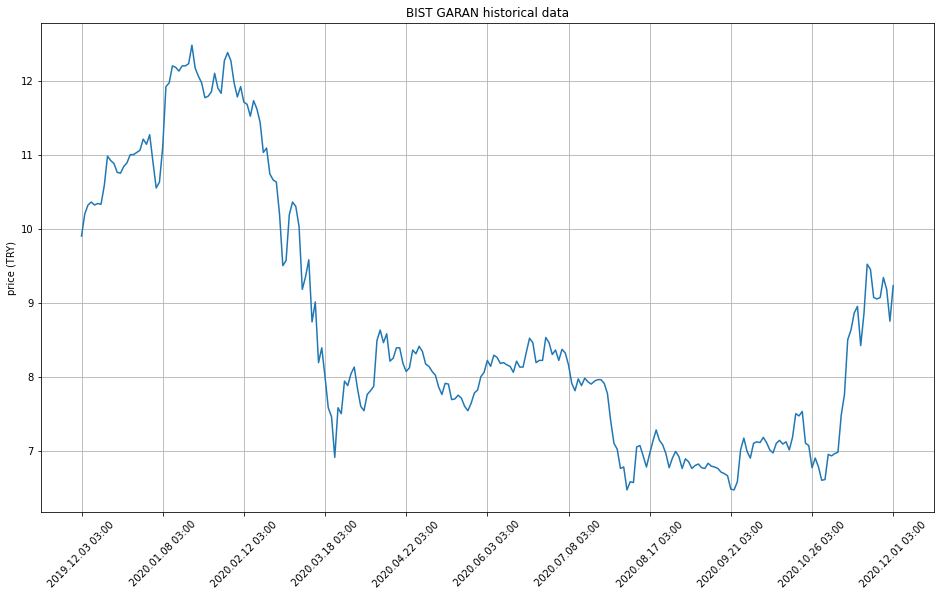

In [7]:
plot_series(code, dates, vals)

# Luckily we have last year's BIST data in our hands

In [8]:
df = pd.read_csv('data/stock/bist-stocks.csv', '\t')

In [9]:
df

,DATE,AFYON,AKBNK,AKSA,AKSEN,ALGYO,ALARK,ALBRK,AEFES,ANELE,...,TCELL,HALKB,ISCTR,ULKER,VAKBN,VERUS,VESTL,YKBNK,YATAS,ZOREN
0,1575331200000,1.97,7.64,6.34,3.78,14.70,5.28,1.20,20.36,3.02,...,13.02,5.78,6.06,21.50,5.09,17.59,11.49,2.40,6.45,1.41
1,1575417600000,1.96,7.71,6.38,3.82,14.79,5.33,1.21,19.91,3.07,...,13.18,5.80,6.17,21.46,5.20,17.72,11.73,2.40,6.47,1.47
2,1575504000000,2.04,7.76,6.36,3.84,15.15,5.44,1.24,19.86,3.08,...,13.50,5.93,6.25,21.90,5.24,17.84,11.80,2.45,6.88,1.48
3,1575590400000,2.05,7.77,6.56,3.81,15.27,5.41,1.29,20.08,3.11,...,13.52,5.87,6.20,21.72,5.10,17.99,12.15,2.47,6.47,1.47
4,1575849600000,2.09,7.67,6.70,3.89,15.23,5.34,1.31,20.08,3.13,...,13.22,5.80,6.13,21.36,5.12,18.15,12.26,2.46,6.54,1.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,1606262400000,4.56,6.30,10.73,7.05,18.37,6.40,1.72,22.16,3.25,...,15.32,5.33,6.69,22.08,4.68,43.24,19.96,3.01,11.86,2.72
247,1606348800000,4.48,6.45,10.81,7.04,18.11,6.32,1.73,23.48,3.35,...,15.48,5.45,6.80,22.24,4.81,45.52,20.00,3.07,11.58,2.80
248,1606435200000,4.50,6.38,10.63,7.12,18.61,6.39,1.71,23.28,3.38,...,15.35,5.42,6.80,22.26,4.76,44.68,20.68,2.99,11.80,2.73
249,1606694400000,4.52,6.02,10.69,7.00,19.69,6.32,1.70,22.48,3.20,...,14.80,5.35,6.51,22.20,4.54,43.42,20.00,2.86,11.96,2.66


# So we will use them all to train our XGB model

In [10]:
dates, vals = [], []

val_code = random.choice(df.columns)

print(f'We will use "{val_code}" to play a trading game at the end!')

for col in df.columns:
    if col == 'DATE' or col == val_code:
        pass
    else:
        dates += list(df['DATE'])
        vals  += list(df[col])
        
len(dates), len(vals)

We will use "EGEEN" to play a trading game at the end!


(24096, 24096)

In [11]:
# prepare data pairs
# each point in the format:
# (data pts n through n+window_size, data pt n+window_size+1)
def get_window_data(v, window_size=5):
    
    v = vals.copy()
    
    pairs = zip([ v[i-window_size:i] for i in range(window_size, len(v))], v[window_size:])

    pairs = list(pairs)

    pairs_list = [ [list(t[0]), t[1]] for t in pairs ] 
    
    return pairs_list

In [12]:
# given windowed pairs, return extracted features
def get_window_ftrs(pairs_list, feature, normalize=True):

    if normalize:
        for pair in pairs_list:
            mux = np.max(pair[0])
            pair[0] /= mux
            pair[1] /= mux
            
            avg = np.mean(pair[0])
            pair[0] -= avg
            pair[1] -= avg
            

    pairs_list = np.array(pairs_list)

    # choose feature
    if feature == "min":
        ftrvals = list(map(np.min, pairs_list[:,0]))
    elif feature == "max":
        ftrvals = list(map(np.min, pairs_list[:,0]))
    elif feature == "std":
        ftrvals = list(map(np.std, pairs_list[:,0]))
    elif feature == "prod":
        ftrvals = list(map(np.prod, pairs_list[:,0]))
    elif feature == "var":
        ftrvals = list(map(np.var, pairs_list[:,0]))
    elif feature == "argmin":
        ftrvals = list(map(np.argmin, pairs_list[:,0]))
    elif feature == "argmax":
        ftrvals = list(map(np.argmax, pairs_list[:,0]))
    elif feature == "median":
        ftrvals = list(map(np.median, pairs_list[:,0]))
    elif feature == "diff":
        ftrvals = list(map(np.diff, pairs_list[:,0]))
    elif feature == "absdiff":
        ftrvals = list(map(np.diff, pairs_list[:,0]))
        ftrvals = list(map(np.abs, ftrvals))
    elif feature == "meandiff":
        ftrvals = list(map(np.diff, pairs_list[:,0]))
        ftrvals = list(map(np.mean, ftrvals))
    elif feature == "skew":
        ftrvals = list(map(skew, pairs_list[:,0]))
    elif feature == "kurtosis":
        ftrvals = list(map(kurtosis, pairs_list[:,0]))   
    elif feature == "absstd":
        ftrvals = list(map(np.abs, pairs_list[:,0]))   
        ftrvals = list(map(np.std, ftrvals))   
    else:
        print("error", feature)

    return ftrvals, pairs_list[:,1]

In [13]:
# best fitting line for datapts (x,y)
def line_fit(x, y):
    coeffs = np.polyfit(x, y, 1)
    return x, x*coeffs[0] + coeffs[1], coeffs[0]

In [14]:
def get_cumulative_features(vals, draw=False):

    # window sizes
    wss  = [4,5,6,7,8,9,10,11,12]

    # features
    ftrs = [
        'std', 
        'max', 
        'min',
        'var',
        'prod',
        'median',
        'argmin',
        'argmax',
        'diff',
        'absdiff',
        'meandiff',
        'absstd',
    ]

    # cumulative
    cum_features = []

    # calculate sets of features
    for ftr in ftrs:  
        # for each window size
        for ws in wss:

            pairs_list       = get_window_data(vals, window_size=ws)

            ftrs, endresults = get_window_ftrs(pairs_list, feature=ftr)  

            # multiple values returned by feature extraction
            try:
                ftrs[0][0] # throws the Exception if single value

                numf = len(ftrs[0])

                for i in range(numf):
                    f = np.array(ftrs[(wss[-1]-ws):])[:,i]
                    cum_features.append(f)


            # single value extracted by feature extraction        
            except Exception as e:

                cum_features.append(ftrs[(wss[-1]-ws):])

            # plot feature with best fitting line
            if draw:
                
                # get fitting line
                x, y, slope = line_fit(
                    np.array(ftrs).astype('float'), 
                    np.array(endresults).astype('float')
                )

                plt.figure()
                plt.scatter(ftrs, endresults)

                plt.xlabel(f'{ftr} of last {ws} values (normalized) ')
                plt.ylabel(f'change in next stock price value (TRY, normalized)')

                plt.plot(x,y, color='orange', label=f'{slope:.2f} slope')

                plt.legend()
                
    return np.vstack(cum_features)

In [15]:
def prepare_data(vals, all_features):

    # get data pairs
    pairs_list    = get_window_data(vals, window_size=5)
    print(pairs_list)
    _, endresults = get_window_ftrs(pairs_list, feature='max')

    # native values (window data)
    nv = [ array[0] for array in pairs_list ][(len(pairs_list)-len(all_features.T)):] 

    # all calculated features and window
    X = np.hstack([all_features.T, np.array(nv)])
    
    # normalized target values
    y = endresults[(len(pairs_list)-len(all_features.T)):] 
    
    # numpy array
    X = np.array(X)
    y = np.array(y)
    
    return X, y
    

In [16]:
def shuffle_data(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X = X[indices]
    y = y[indices]
    
    return X, y

In [17]:
def test_split(X, y, test_ratio):

    split_index = int(len(X)*(1-test_ratio))

    X_train = X[:split_index]
    y_train = y[:split_index]

    X_test  = X[split_index:]
    y_test  = y[split_index:]
    
    print(f'X_train:\t{X_train.shape}')
    print(f'y_train:\t{y_train.shape}')
    print(f'X_test: \t{X_test.shape}')
    print(f'y_test: \t{y_test.shape}')
    
    return X_train, y_train, X_test, y_test


In [18]:
%%time

all_features = get_cumulative_features(vals)

X, y = prepare_data(vals, all_features)

X, y = shuffle_data(X, y)

test_ratio  = .2

splits = test_split(X, y, test_ratio)

X_train = splits[0]
y_train = splits[1]
X_test  = splits[2]
y_test  = splits[3]

[[[1.97, 1.96, 2.04, 2.05, 2.09], 2.5], [[1.96, 2.04, 2.05, 2.09, 2.5], 2.39], [[2.04, 2.05, 2.09, 2.5, 2.39], 2.3], [[2.05, 2.09, 2.5, 2.39, 2.3], 2.35], [[2.09, 2.5, 2.39, 2.3, 2.35], 2.32], [[2.5, 2.39, 2.3, 2.35, 2.32], 2.35], [[2.39, 2.3, 2.35, 2.32, 2.35], 2.33], [[2.3, 2.35, 2.32, 2.35, 2.33], 2.25], [[2.35, 2.32, 2.35, 2.33, 2.25], 2.26], [[2.32, 2.35, 2.33, 2.25, 2.26], 2.22], [[2.35, 2.33, 2.25, 2.26, 2.22], 2.2], [[2.33, 2.25, 2.26, 2.22, 2.2], 2.25], [[2.25, 2.26, 2.22, 2.2, 2.25], 2.33], [[2.26, 2.22, 2.2, 2.25, 2.33], 2.4], [[2.22, 2.2, 2.25, 2.33, 2.4], 2.34], [[2.2, 2.25, 2.33, 2.4, 2.34], 2.27], [[2.25, 2.33, 2.4, 2.34, 2.27], 2.28], [[2.33, 2.4, 2.34, 2.27, 2.28], 2.3], [[2.4, 2.34, 2.27, 2.28, 2.3], 2.21], [[2.34, 2.27, 2.28, 2.3, 2.21], 2.07], [[2.27, 2.28, 2.3, 2.21, 2.07], 2.23], [[2.28, 2.3, 2.21, 2.07, 2.23], 2.22], [[2.3, 2.21, 2.07, 2.23, 2.22], 2.33], [[2.21, 2.07, 2.23, 2.22, 2.33], 2.34], [[2.07, 2.23, 2.22, 2.33, 2.34], 2.41], [[2.23, 2.22, 2.33, 2.34, 2.4

X_train:	(19267, 221)
y_train:	(19267,)
X_test: 	(4817, 221)
y_test: 	(4817,)
CPU times: user 1min 20s, sys: 646 ms, total: 1min 21s
Wall time: 1min 21s


In [19]:
# xgboost
import xgboost

# define model
model = xgboost.XGBRegressor()

In [20]:
%%time
model.fit(X_train, y_train)

CPU times: user 1min 44s, sys: 87.5 ms, total: 1min 44s
Wall time: 13.8 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

MAE: 0.053975985014316524
MSE: 0.2514213086961388
CPU times: user 284 ms, sys: 4 ms, total: 288 ms
Wall time: 110 ms


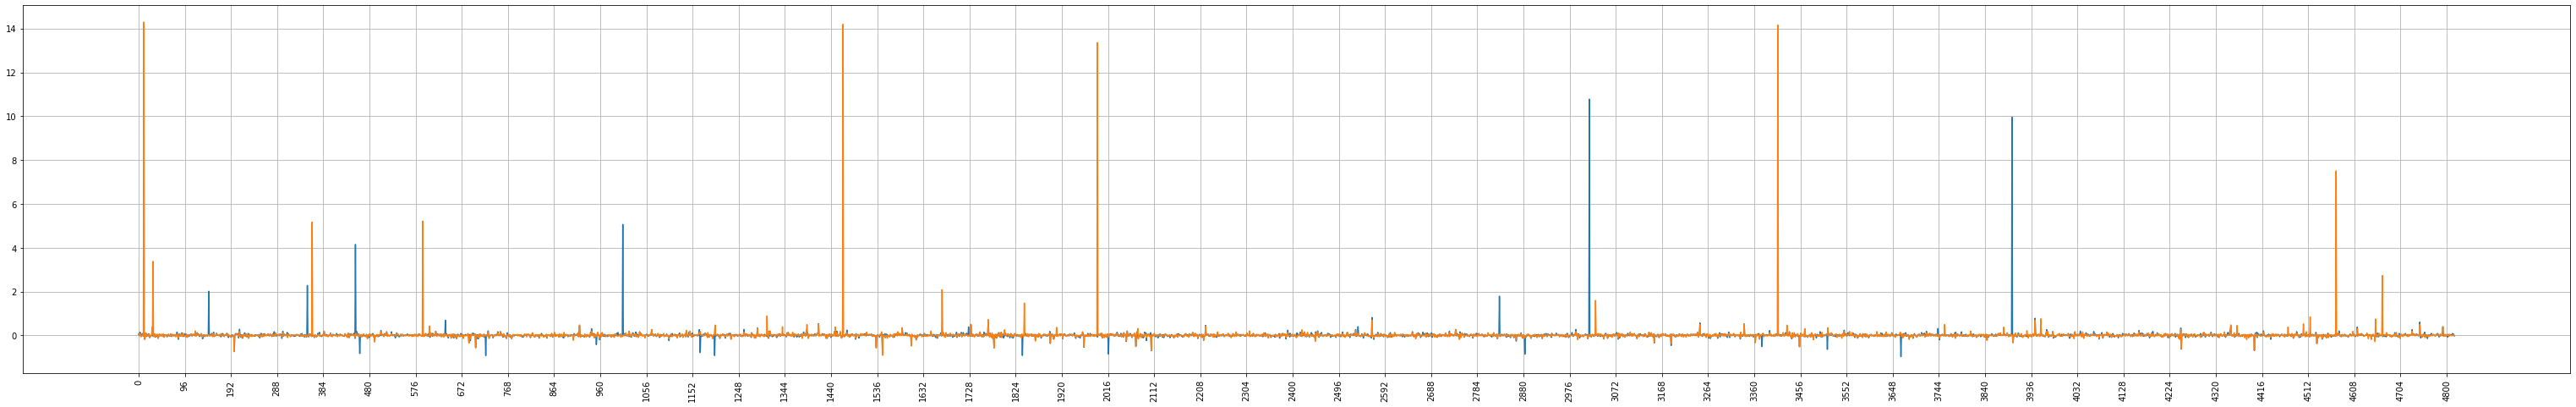

In [21]:
%%time
y_pred = model.predict(X_test)

print('MAE:', np.sum(np.abs(y_pred-y_test))/len(y_test))
print('MSE:', np.sum(np.abs(y_pred-y_test)**2)/len(y_test))

plt.figure(figsize=(54,8))
plt.plot(y_test)
plt.plot(y_pred)
plt.xticks(list(range(len(y_pred)))[::int(len(y_pred)/50)], rotation=90)
plt.grid()

In [22]:
increase_test = [ 1 if value > 0 else 0 for value in y_test ]
increase_pred = [ 1 if value > 0 else 0 for value in y_pred ]

m = confusion_matrix(increase_test, increase_pred)

print('Confusion matrix:')
print(m, '\n')

print('{:.2f}% True Positives'.format(m[1,1]/(m[1,1]+m[0,1])))
print('{:.2f}% True Negatives'.format(m[0,0]/(m[1,0]+m[0,0])))

# tn fp 
# fn tp

Confusion matrix:
[[1500  637]
 [ 495 2185]] 

0.77% True Positives
0.75% True Negatives


# Let's test it out on a random stock

251 datapoints returned by the API
[[[468.76, 479.22, 498.99, 505.87, 505.39], 501.12], [[479.22, 498.99, 505.87, 505.39, 501.12], 505.87], [[498.99, 505.87, 505.39, 501.12, 505.87], 503.26], [[505.87, 505.39, 501.12, 505.87, 503.26], 523.32], [[505.39, 501.12, 505.87, 503.26, 523.32], 536.88], [[501.12, 505.87, 503.26, 523.32, 536.88], 546.58], [[505.87, 503.26, 523.32, 536.88, 546.58], 538.05], [[503.26, 523.32, 536.88, 546.58, 538.05], 543.76], [[523.32, 536.88, 546.58, 538.05, 543.76], 543.86], [[536.88, 546.58, 538.05, 543.76, 543.86], 540.76], [[546.58, 538.05, 543.76, 543.86, 540.76], 538.14], [[538.05, 543.76, 543.86, 540.76, 538.14], 538.82], [[543.76, 543.86, 540.76, 538.14, 538.82], 534.95], [[543.86, 540.76, 538.14, 538.82, 534.95], 534.95], [[540.76, 538.14, 538.82, 534.95, 534.95], 545.61], [[538.14, 538.82, 534.95, 534.95, 545.61], 562.57], [[538.82, 534.95, 534.95, 545.61, 562.57], 558.98], [[534.95, 534.95, 545.61, 562.57, 558.98], 549.19], [[534.95, 545.61, 562.57, 55

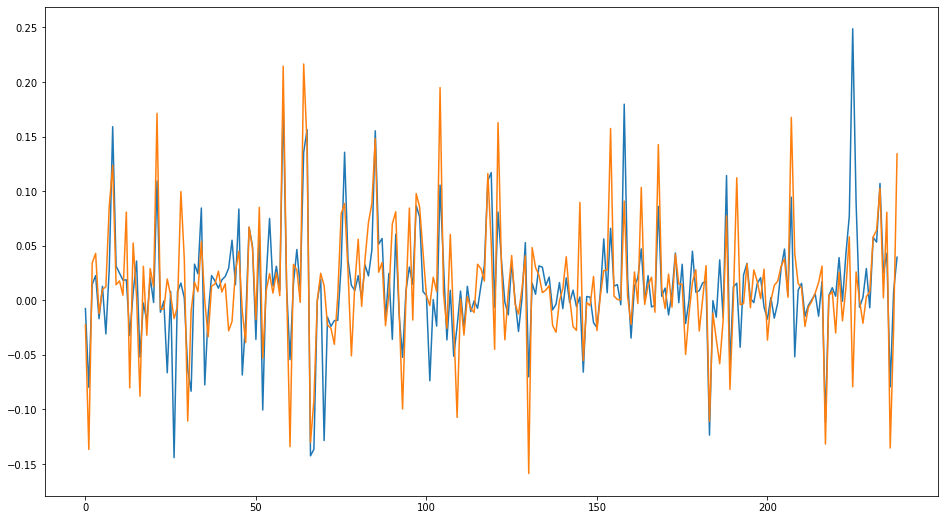

In [23]:
# the validation stock we 
# randomly chose from the df
code         = val_code

series       = get_oyak_data(code, 3)

dates, vals  = get_dates_vals(series)

all_features = get_cumulative_features(vals)

X, y = prepare_data(vals, all_features)

X, y = shuffle_data(X, y)

y_pred = model.predict(X)

plt.figure(figsize=(16,9))
plt.plot(y_pred)
plt.plot(y)

# lets see how well we predicted increases and decreases in the stock

In [24]:
increase_test = [ 1 if value > 0 else 0 for value in y ]
increase_pred = [ 1 if value > 0 else 0 for value in y_pred ]

m = confusion_matrix(increase_test, increase_pred)

print('Confusion matrix:')
print(m, '\n')

print('{:.2f}% True Positives'.format(m[1,1]/(m[1,1]+m[0,1])))
print('{:.2f}% True Negatives'.format(m[0,0]/(m[1,0]+m[0,0])))

# tn fp 
# fn tp

Confusion matrix:
[[ 61  25]
 [ 25 128]] 

0.84% True Positives
0.71% True Negatives


In [25]:
len(vals[(len(vals)-len(y)-1):-1]), len(y)

(239, 239)

In [26]:
prices = vals[(len(vals)-len(y)):-1]

In [27]:
kapital = 100

cash    = kapital
stock   = 0

for i, val in enumerate(y):
    
    if i == 0:
        continue
    
    todays_price = prices[i-1]
    
    # if next day will be - : sell
    if val < 0:
        cash  += stock*todays_price
        stock  = 0
    # if next day will be + : buy or hold
    else:
        stock += cash/todays_price
        cash   = 0
        
end_cash  = cash + stock*todays_price

days_past = (secs_to_date(series[:,0][-1])-secs_to_date(series[:,0][-len(y)])).days

print(f'{100*((end_cash-kapital)/kapital):.2f}% return in {days_past} days')
print()
print(f'{kapital}TRY to {end_cash:.2f}TRY')

101.65% return in 348 days

100TRY to 201.65TRY


## 💸 Compare to Nov19-Nov20 USD/TRY return of 24%